In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

In [4]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/user_study/evaluation_study/transcription_and_analysis/"

In [5]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

In [6]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

In [7]:
def dcg(r, k, method=0):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)):
        val+= (2**r[i]-1) / np.log2(i+1)
    return val

def ndcg(dcg_ground_truth,r, k):
    return dcg(r, k) / sum(dcg_ground_truth)

In [17]:
ndcg([1,2,3,4,5,6],[3,2,3,0,1,2],6)

0.4289401549893915

In [8]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    k = len(ground_truth_rank["attribute"])
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        #print (trial)
        ndcg_d.append(trial[0])
        #for k in k_lst:
        ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
#             print trial[1]
        ndcg_data.append(ndcg_d)
#    print ndcg_data
    NDCG_lst = ["NDCG@"+str(k)]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task"]+NDCG_lst)
    #print (ndcg_result)
    return ndcg_result.groupby("Task",as_index=False).mean()

In [9]:
# user_ranking_filename = "Ranking(Police).csv"
# gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
def compute_ndcg_rankings_exclude_unranked(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)

    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    ndcg_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Recompute the ground truth rating after throwing away unrated instances
        ranking = np.array(ranking)
        unrated_idxs =  np.where(ranking==0)[0]
        new_ranking = list(np.delete(ranking, unrated_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),unrated_idxs)
        assert len(new_ranking) == len(new_CramerV)
        k = len(new_ranking)
        ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        #Computing ndcg ranking
        ndcg_d = []
        ndcg_d.append(task)
        ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,k)
        print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
        ndcg_d.append(ndcg_val)
        ndcg_d.append(k)
        ndcg_data.append(ndcg_d)
    #    print ndcg_data
    NDCG_lst = ["NDCG@k"]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG@k","k"])
    return ndcg_result

In [10]:
ndcg_result = compute_ndcg_rankings_exclude_unranked("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")

[5.0, 2.0, 3.0, 1.0, 4.0] [3.0, 1.0, 1.5, 2.0, 3.0] 0.4445563321168823
[5.0, 2.0, 3.0, 1.0, 4.0] [4.0, 2.0, 2.0, 1.0, 3.0] 0.5605016778152083
[5.0, 2.0, 3.0, 1.0, 4.0] [4.0, 2.0, 5.0, 1.0, 3.0] 1.7382372178152623
[2.0, 1.0] [2.0, 1.0] 0.3333333333333333
[2.0, 1.0] [2.0, 1.0] 0.3333333333333333
[7.0, 5.0, 2.0, 3.0, 1.0, 6.0, 4.0] [3.0, 1.0, 2.0, 4.0, 6.0, 7.0, 5.0] 3.4892193478026288
[5.0, 2.0, 3.0, 1.0, 4.0] [4.0, 3.0, 2.0, 1.0, 5.0] 1.516250837399304
[2.0, 3.0, 1.0] [2.0, 2.0, 1.0] 0.6051549589285763
[3.0, 2.0, 1.0] [1.0, 3.0, 2.0] 1.4821315434523956
[3.0, 2.0, 1.0] [3.0, 1.0, 2.0] 0.4821315434523954
[3.0, 1.0, 2.0] [3.0, 2.0, 1.0] 0.6051549589285763
[3.0, 2.0, 1.0] [3.0, 2.0, 1.0] 0.6051549589285763
[5.0, 2.0, 3.0, 1.0, 4.0] [3.0, 2.0, 2.0, 1.0, 3.0] 0.5605016778152083
[5.0, 2.0, 3.0, 1.0, 4.0] [4.0, 3.0, 2.0, 1.0, 2.0] 0.7123212623289702
[5.0, 3.0, 1.0, 4.0, 2.0] [5.0, 2.0, 3.0, 1.0, 4.0] 0.95844377640674
[3.0, 1.0, 4.0, 2.0] [3.0, 1.0, 3.0, 2.0] 0.6916508275000203
[3.0, 2.0, 1.0] [

In [11]:
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,A1,0.733214,4.666667
1,A2,0.947655,3.666667
2,A3,1.126606,4.000000


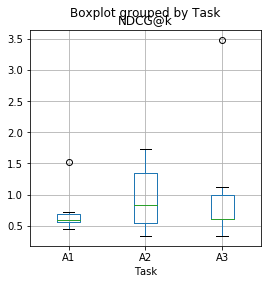

In [12]:
ndcg_result.boxplot("NDCG@k",by="Task")

In [13]:
ndcg_result = compute_ndcg_rankings_exclude_unranked("Ranking(Autism).csv","autism_ground_truth_correlation.csv")

[6.0, 5.0, 3.0, 2.0, 4.0, 1.0] [2, 3, 1, 3, 5, 4] 1.442128341064989
[5.0, 4.0, 3.0, 2.0, 1.0] [5, 4, 3, 2, 1] 1.4231456555382398
[5.0, 2.0, 4.0, 1.0, 3.0] [2, 1, 3, 1, 4] 0.8251104430734065
[4.0, 3.0, 2.0, 1.0] [1, 4, 3, 2] 2.0916508275000205
[5.0, 2.0, 4.0, 1.0, 3.0] [2, 1, 4, 3, 5] 1.8209946402564698
[4.0, 3.0, 2.0, 1.0] [1, 1, 1, 2] 0.31309297535714575
[7.0, 6.0, 4.0, 3.0, 2.0, 5.0, 1.0] [5, 3, 3, 5, 1, 4, 2] 1.2220928036755638
[4.0, 3.0, 2.0, 1.0] [1, 1, 1, 1] 0.21309297535714578
[4.0, 2.0, 3.0, 1.0] [1, 2, 4, 3] 1.5963946303571863
[5.0, 4.0, 3.0, 2.0, 1.0] [1, 1, 1, 1, 2] 0.22819729518610915
[3.0, 2.0, 1.0] [1, 2, 3] 1.2360847125000338
[7.0, 6.0, 4.0, 3.0, 2.0, 5.0, 1.0] [2, 1, 2, 1, 2, 2, 1] 0.22148516227664997
[7.0, 6.0, 4.0, 3.0, 2.0, 5.0, 1.0] [3, 3, 2, 2, 1, 3, 4] 0.6740908312874961
[4.0, 3.0, 2.0, 1.0] [1, 3, 2, 2] 1.0392789260714372
[7.0, 4.0, 3.0, 2.0, 6.0, 1.0, 5.0] [1, 6, 3, 2, 7, 4, 5] 5.016344502113855
[4.0, 3.0, 2.0, 1.0] [1, 4, 3, 2] 2.0916508275000205
[4.0, 3.0, 2.0

In [14]:
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,B1,1.975762,4.833333
1,B2,0.845206,6.333333
2,B3,1.181169,4.333333


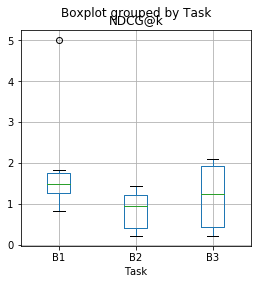

In [15]:
ndcg_result.boxplot("NDCG@k",by="Task")

In [92]:
user_rank = pd.read_csv(gdrive_path+"Ranking(Autism).csv",index_col=0)
ground_truth=pd.read_csv("autism_ground_truth_correlation.csv")

In [94]:
ground_truth

,Unnamed: 0,attribute,chi2,p,cramerV
0,0,a1_score,60.872476,6.089428e-15,0.297628
1,1,a2_score,66.854644,2.922829e-16,0.311382
2,2,a3_score,134.969840,3.352225e-31,0.441074
3,3,a4_score,153.363610,3.190121e-35,0.469945
4,4,a5_score,200.598762,1.545858e-45,0.537004
5,5,a6_score,243.848791,5.695403e-55,0.592091
6,6,a7_score,85.344911,2.506061e-20,0.351429
7,7,a8_score,38.483164,5.522806e-10,0.237161
8,8,a9_score,281.328867,3.854920e-63,0.635576
9,9,a10_score,103.094543,3.195300e-24,0.385917


In [90]:
user_rank

,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,a10_score,Note
User,,,,,,,,,,,
1,2,3,0,0,1,3,5,0,4,0,"User indicated that a2,a6, and a9 may only be ..."
2,5,4,3,2,1,0,0,0,0,0,User hypothesizes that higher question numbers...
3,0,2,0,0,0,1,3,0,1,4,Used the upper level visualization for the rea...
4,1,4,3,2,0,0,0,0,0,0,Ranked based on seen visualization based on ho...
5,0,2,0,0,0,1,4,0,3,5,NaN
6,1,1,0,0,0,1,0,0,2,0,NaN
7,5,3,3,0,5,1,4,0,2,0,NaN
8,1,1,1,1,0,0,0,0,0,0,NaN
9,0,1,0,0,0,2,4,0,3,0,User traced from bottom up a visualization tha...


In [87]:
ndcg_result

,Task,NDCG@k,k
0,B2,1.442128,6
1,B3,1.423146,5
2,B1,0.825110,5
3,B3,2.091651,4
4,B1,1.820995,5
5,B2,0.313093,4
6,B2,1.222093,7
7,B3,0.213093,4
8,B1,1.596395,4
9,B3,0.228197,5


In [29]:
ndcg_result=[["Police"]+list(compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")["NDCG@7"]),
["Autism"]+list(compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")["NDCG@10"])]

In [31]:
print (T.tabulate(ndcg_result,headers=['Dataset','\system','Cluster','BFS'],tablefmt='latex', floatfmt=".2f"))

\begin{tabular}{lrrr}
\hline
 Dataset   &   \system &   Cluster &   BFS \\
\hline
 Police    &      0.63 &      0.45 &  0.84 \\
 Autism    &      0.50 &      0.35 &  0.24 \\
\hline
\end{tabular}


- NDCG@1 is 0 because if the first-ranked attribute is not retreived, then score would be 0.
- This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.
- NDCG should be @10 because all users read through and ranked all 10 dashboards.

# Dashboard attribute coverage

In [33]:
import glob
import json
dashboards = glob.glob("generated_dashboards/*")

In [34]:
dashboards

['generated_dashboards/ct_police_stop_stop-outcome_greedy_picking_euclidean_ic0.0_ip0.9_k10.json',
 'generated_dashboards/autism_autism_kmeans_euclidean_ic0.0_ip0.001_k10.json',
 'generated_dashboards/ct_police_stop_stop-outcome_kmeans_euclidean_ic0.0_ip0.001_k10.json',
 'generated_dashboards/ct_police_stop_stop-outcome_levelwiseBFS_euclidean_ic0.0_ip0.001_k10.json',
 'generated_dashboards/autism_autism_levelwiseBFS_euclidean_ic0.0_ip0.001_k10.json',
 'generated_dashboards/autism_autism_greedy_picking_euclidean_ic0.0_ip0.9_k10.json']

In [83]:
dashboard_filters_attributes_only = []
for  dashboard_name in dashboards:
    dashboard = json.load(open(dashboard_name))
    dashboard_filters = []
    for id in dashboard.keys():
        if not (dashboard[id][-1]["filter"]=="#"):
            filters = dashboard[id][-1]["filter"].replace("$","=").split("#")[1:-1]
            dashboard_filters.append(filters)
    dashboard_name = dashboard_name.split("/")[1].split("_euclidean")[0]
    for dashbd in dashboard_filters:
        score = 1/len(dashbd)
        for vis in dashbd:
            dashboard_filters_attributes_only.append([vis[:vis.index("=")],score,dashboard_name])

In [85]:
df = pd.DataFrame(dashboard_filters_attributes_only,columns=["attribute","%mentioned","filename"])

In [87]:
df.groupby(["filename","attribute"],as_index=False).sum()

,filename,attribute,%mentioned
0,autism_autism_greedy_picking,a10_score,1.583333
1,autism_autism_greedy_picking,a2_score,0.250000
2,autism_autism_greedy_picking,a3_score,0.500000
3,autism_autism_greedy_picking,a4_score,0.500000
4,autism_autism_greedy_picking,a6_score,3.083333
5,autism_autism_greedy_picking,a7_score,0.583333
6,autism_autism_greedy_picking,a9_score,2.500000
7,autism_autism_kmeans,a1_score,2.833333
8,autism_autism_kmeans,a2_score,1.333333
9,autism_autism_kmeans,a3_score,1.000000
